# Striking the right balance

### Introduction

We have now been exposed to the three different sources of error that can arise in our model.  Here are the three sources:

* **bias** when our model does not include one or more features that contributes to variations in outcomes of our data.  
* **variance** when we include too many features in our model that make our models too flexible, such that it picks up on randomness in the data.  
* **irreducible error** which occurs due to a degree of randomness in our target variable. 

As we know, we cannot eliminate irreducible error.  But we can develop techniques for not including too few parameters and thus contributing bias, or too many parameters and thus introducing variance, into our model.

### Setting up our data

So far we have seen a model that suffers from bias, one from variance, and another that has the correct number of variables.  Let's review each of these models.

First, let's again load our feature data of `temps`, `is_weekends` and `cashier_age`, and our dependent variable of `customers_with_errors`.

In [9]:
from data import temps, is_weekends, random_ages, customers_with_errors

Now as we know, to create different models, we need create collections that have one or more of these features.  That is also included in our data, so let's load that in.

In [10]:
from data import input_temps, temps_and_is_weekends, temps_weekends_and_ages

In [11]:
input_temps[0:3] # [[30], [31], [32]]
temps_and_is_weekends[0:3] # [(30, 0), (31, 0), (32, 1)]
temps_weekends_and_ages[0:3] # [(30, 0, 28),  (31, 0, 30),  (32, 1, 30)]

[(30, 0, 28), (31, 0, 30), (32, 1, 30)]

### Working with three models

Now to create these three models, we'll just use the same process of inititializing our model, fitting the data and looking at some scores.  With this degree of repetition, let's use a loop.

In [14]:
from sklearn.linear_model import LinearRegression
feature_datasets = [input_temps, temps_and_is_weekends, temps_weekends_and_ages]
models = []
for dataset in feature_datasets:
    model = LinearRegression()
    model.fit(dataset, customers_with_errors)
    models.append(model)
models

[LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False),
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False),
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)]

Now we can use our `map` function to query these models at the same time.

In [18]:
coefs = list(map(lambda model: model.coef_, models))
coefs

[array([2.87988515]),
 array([ 3.07299452, 38.61313304]),
 array([ 3.07698899, 38.62306381, -0.05584566])]

In [20]:
intercepts = coefs = list(map(lambda model: model.intercept_, models))
intercepts

[35.62031572335471, 9.854773197812762, 12.155548281106803]

But some data like predict, requires both the model, and the related dataset.  For example, if we try to predict with our first model that has just one coefficient with data that has two features, it will break.  So let's pair our models with the related input data. 

In [21]:
models_and_data = list(zip(models, feature_datasets))

And now we can use `map` to make predictions with our three models, and then plot them.

In [22]:
predictions = list(map(lambda model_and_data: model_and_data[0].predict(model_and_data[1]), models_and_data))

So now in the line below we'll look at the first three predictions of our first model.

In [24]:
predictions[0][0:3]

array([122.01687025, 124.8967554 , 127.77664055])

And after creating our trace of the data.

In [35]:
from graph import plot, trace_values
data_trace = trace_values(temps, customers_with_errors)

We can create three traces of these predictions.

In [33]:
model_traces = list(map(lambda prediction: trace_values(temps, prediction, mode = 'lines'),predictions))

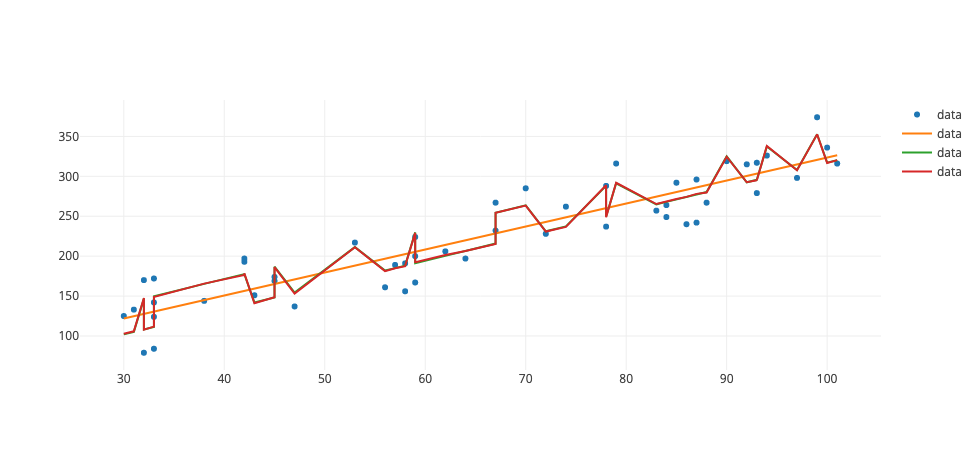

In [34]:
plot([data_trace,*model_traces])

Now it may look like there are only two models, but there are three, and they are different.  Hover your cursor over the plot and you can see the slight differences between our two feature and three feature models.

### Choosing a model

Now let's move into our process for choosing a model.  The first thing we may want to do is look at the scores for each of these models.

In [38]:
list(map(lambda model_and_data: model_and_data[0].score(model_and_data[1], customers_with_errors), models_and_data))

[0.8420038114597748, 0.9059072683379463, 0.9059869378711805]

Now we can see that each of has progressively better scores.

However, as we mentioned previously the new feature in our last model is the influence of our random list of cashier ages to customers.  This model is just using this random list to find an association between cashier age and customers that doesn't exist.  It's simply coincidence that there exists this association.  This is another case of us overfitting to the randomness in the data

### But how do we know?

Now the way to detect this overfitting is the same way we did before: we use a holdout set.  Here's why this should work:

1. **If the association is real**, then the detected association should continue to be informative even on data the our model did not see.  
2. **If the association is not real** then this means that our model just found a random association that is not likely to be replicated on the holdout set.

Ok, let's try it.  We'll create holdout sets by splitting our data into a group of holdout training data and holdout data.

In [74]:
split_datasets = []
for dataset in feature_datasets:
    training_data = dataset[:30]
    holdout_data = dataset[30:]
    split_dataset = (training_data, holdout_data)
    split_datasets.append(split_dataset)

So for each of our feature datasets, we placed the first thirty elements into `training_data` and the remaining data into `holdout_data`.  So for example, if we want to see first elements of our holdout dataset for that only includes the `temp` feature, we should go to the first element in our split dataset, and then find the second element which contains that holdout data. 

In [76]:
holdout_data_first_dataset = split_datasets[0][1]
holdout_data_first_dataset[0:3]

[[78], [78], [79]]

Now remember that if we believe our feature does really help, then when it finds an association in our training dataset which produces a certain score, we should be able to show that this is not our model just matching to some association found in the randomness of the data.  We'll be able to show this if this now trained model is also predictive with our holdout dataset.

So let's first train the three models on the training datasets.

In [104]:
training_models = []
for dataset in split_datasets:
    model = LinearRegression()
    training_feature_data = dataset[0]
    model.fit(training_feature_data, customers_with_errors[0:30])
    training_models.append(model)
training_models

[LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False),
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False),
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)]

In [105]:
list(map(lambda training_model: training_model.coef_ , training_models))

[array([2.83631714]),
 array([ 3.19619175, 41.15656982]),
 array([ 3.35363479, 42.63582233, -0.58347836])]

And we can get the related scores.

In [108]:
split_models_with_data = list(zip(training_models, split_datasets))

In [109]:
training_scores = []
for split_model_with_data in split_models_with_data:
    selected_model = split_model_with_data[0]
    training_data = split_model_with_data[1][0]
    score = selected_model.score(training_data, customers_with_errors[:30])
    training_scores.append(score)

In [110]:
training_scores

[0.6623863190118378, 0.8252525407686737, 0.8440593106882044]

So as we can see on our training data, our models continue to improve with every new parameter that we add.

Now let's see how each of our models performs with our holdout data.

In [113]:
holdout_scores = []
for split_model_with_data in split_models_with_data:
    selected_model = split_model_with_data[0]
    holdout_data = split_model_with_data[1][1]
    score = selected_model.score(holdout_data, customers_with_errors[30:])
    holdout_scores.append(score)

In [114]:
holdout_scores

[0.4036896487296144, 0.5465540739803845, 0.35116461377626523]

So here we can see that our models do not improve with each added parameter.  Rather we see that our bias variance tradeoff reflected in these scores.  The first score is for our one parameter model, which is biased.  Then the second score has our two parameter model, which has the proper features of temps and weekend.  And our final model has three an irrelevant parameter of `random_ages` and thus suffers from variance. 

| model                  |train score | holdout score |  
| ---------------------- |:----------:| :------------:|
| temps, ages, weekend   | .66        |  .40          |
| temps, weekend         | .82        |  .54      
| temps                  | .84        |  .35         | 

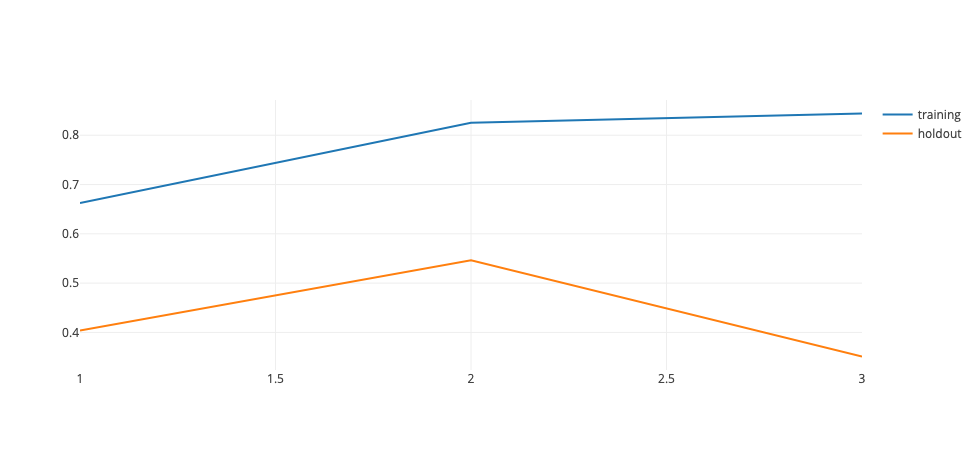

In [118]:
model_parameters = [1, 2, 3]
training_trace = trace_values(model_parameters, training_scores, mode = 'lines', name = 'training')
holdout_trace = trace_values(model_parameters, holdout_scores, mode = 'lines', name = 'holdout')
plot([training_trace, holdout_trace])

The above is a typical graph in machine learning.  As we add more features, the training scores tend to continue to improve.  However, at a certain point adding too many features has our model suffer from variance, so our holdout scores do not continue to improve.  The peak of our holdout scores is showing our best version of the model, which is the second model.

### Summary